In [ ]:
# Check PyTorch and CUDA installation
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available()) 

2.7.1+cu118
11.8
NVIDIA GeForce GTX 1050 Ti
True


### Sparse Layers:
Sparse data'larla (seyrek veriler) çalışması sağlayan bir katmandır. Genellikle recommendation systemlerde kullanılır. Embedding, embedding-back layer'larını içerir.

**torch.nn.Embedding:**

En sık kullanılan sparse layer'lardan biridir. Genellikle token'ların embed edilmesi için kullanılır.

```python
import torch
import torch.nn as nn

embedding = nn.Embedding(num_embeddings=1000, embedding_dim=64, sparse=True)
input = torch.LongTensor([1, 5, 999])
output = embedding(input)
```

* **sparse=True** demek, backpropagation sırasında sadece kullanılan embedding vektörlerinin gradyanlarının hesaplanacağı anlamına gelir. Bu, eğitim sırasında büyük bellek ve zaman tasarrufu sağlar.

### torch.nn.functional:
Bu modül, 

* convolution layers, 
* pooling layers, 
* scaled dog product attention, 
* non-linear activation functions, 
* linear activation functions, 
* dropout functions, 
* sparse functions, 
* distance functions, 
* loss function, 
* vision functions 
* data parallel functions (multi-gpu) 

sağlar.

# Build ANN With MNIST Dataset Using PyTorch

In [2]:
import torch # Tensor
import torch.nn as nn # For defining neural networks
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset
# Batch size is the number of samples processed during every iteration
def load_data(batch_size=64):
    """Load the MNIST dataset and return data loaders for training and testing."""
    transform = transforms.Compose([
        transforms.ToTensor(), # Convert PIL Image to Tensor and normalize [0, 255] to [0.0, 1.0]
        transforms.Normalize((0.5,), (0.5,)) # Scaling the data to [-1, 1]
    ])
    
    # Download the MNIST dataset as training and test datasets
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Create data loaders for training and testing datasets
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

train_loader, test_loader = load_data()

In [3]:
train_loader.dataset.data.shape # Train data has 60000 samples, 28x28 pixels each

torch.Size([60000, 28, 28])

In [4]:
test_loader.dataset.data.shape # Test data has 10000 samples, 28x28 pixels each

torch.Size([10000, 28, 28])

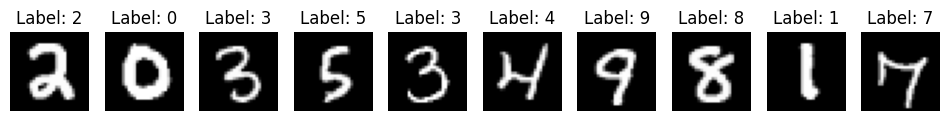

In [5]:
# Data Visualization
def visualize_data(train_loader, num_samples=10):
    """Visualize a few samples from the training dataset."""
    images, labels = next(iter(train_loader)) # Get the next batch of images and labels
    
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
    for i in range(num_samples):
        axes[i].imshow(images[i][0], cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off') # Hide axes
    plt.show()
    
visualize_data(train_loader, num_samples=10)

In [ ]:
def check_shape_and_dtype(loader):
    images, labels = next(iter(loader))
    print(f"Image shape: {images.shape}, Image dtype: {images.dtype}") 
    print(f"Label shape: {labels.shape}, Label dtype: {labels.dtype}")

check_shape_and_dtype(train_loader)

Image shape: torch.Size([64, 1, 28, 28]), Image dtype: torch.float32
Label shape: torch.Size([64]), Label dtype: torch.int64


**Image shape:** 64 samples, 1 channel, 28x28 pixels each

In [7]:
# Define the Neural Network

class SimpleANN(nn.Module):
    """A simple Artificial Neural Network for MNIST classification."""
    # Initialize the neural network layers (Not Built yet!)
    def __init__(self):
        super(SimpleANN, self).__init__()
        # Create a flatten layer to convert 2D images to 1D vectors
        self.flatten = nn.Flatten()
        
        # Create first full connected layer
        self.fc1 = nn.Linear(28 * 28, 128) # 784 input features (28x28 pixels), 128 output features
        
        # Create activation function
        self.relu = nn.ReLU()
        
        # Create second full connected layer
        self.fc2 = nn.Linear(128, 64) # 128 input features, 64 output features
        
        # Create output layer
        self.fc3 = nn.Linear(64, 10) # 64 input features, 10 output features (for 10 classes)
    
    def forward(self, x):
        """Define the forward pass of the network."""
        # x = 28x28 images, we need to flatten them to 1D vectors
        x = self.flatten(x) # Flatten the input image
        x = self.fc1(x) # Pass through first layer
        x = self.relu(x) # Apply ReLU activation
        x = self.fc2(x) # Pass through second layer
        x = self.relu(x) # Apply ReLU activation (Optional)
        x = self.fc3(x) # Pass through output layer
        return x # Return the output logits

In [8]:
model = SimpleANN().to(device) # Move the model to the device (GPU or CPU)

In [9]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss() # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate

In [10]:
# Training the Model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    """Train the model on the training dataset."""
    model.train() # Set the model to training mode
    
    running_losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # Move data to device
            
            optimizer.zero_grad() # Zero the gradients (Because we don't want to use previous gradients)
            
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward() # Backward pass (Calculate gradients)
            optimizer.step() # Update weights
            
            total_loss += loss.item() # Accumulate loss
        
        avg_loss = total_loss / len(train_loader) # Average loss for the epoch
        running_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), running_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

Epoch [1/5], Loss: 0.3949
Epoch [2/5], Loss: 0.1866
Epoch [3/5], Loss: 0.1371
Epoch [4/5], Loss: 0.1111
Epoch [5/5], Loss: 0.0942


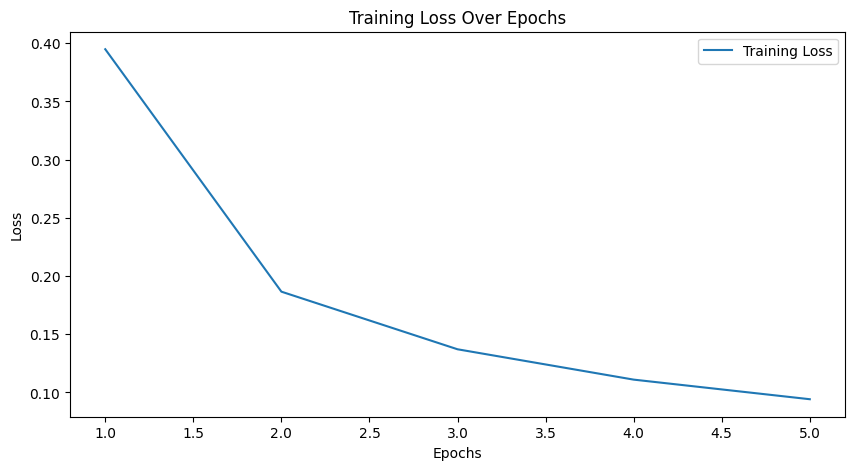

In [11]:
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

In [12]:
# Testing the Model and Evaluating Performance
def test_model(model, test_loader):
    """Test the model on the test dataset and evaluate its performance."""
    model.eval() # Set the model to evaluation mode
    correct = 0 # Number of correct predictions
    total = 0 # Total number of samples
    
    with torch.no_grad(): # No need to calculate gradients during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # Move data to device
            
            predictions = model(images) # Forward pass
            
            _, predicted_idx = torch.max(predictions, 1) # Get the highest predicted class index
            total += labels.size(0) # Update total samples
            correct += (predicted_idx == labels).sum().item() # Count correct predictions
    
    accuracy = 100 * correct / total # Calculate accuracy
    print(f'Test Accuracy: {accuracy:.3f}%')

In [13]:
test_model(model, test_loader) # Test the model on the test dataset

Test Accuracy: 96.810%
